# 8DB4 PDB에서 Chain E 추출

In [3]:
from pathlib import Path
import requests

# Bio.PDB 관련 클래스들: 구조 파싱/정합(Superimposer), CIF 메타데이터 파싱(MMCIF2Dict)에 사용.
from Bio.PDB import PDBParser, Superimposer
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
import numpy as np

# 현재 작업 디렉터리 아래 8DB4_fix/ 폴더를 만들고(이미 있으면 무시), 그 안에 파일을 저장
PDB_ID = "8DB4"
work = Path("8DB4_fix"); work.mkdir(exist_ok=True)

# pdb 다운로드 함수
# 이미 파일이 있으면 재다운로드하지 않고 기존 파일 경로만 반환
def dl(url, path):
    if not path.exists():
        r = requests.get(url, timeout=60); r.raise_for_status()
        path.write_bytes(r.content)
    return path

pdb_path = dl(f"https://files.rcsb.org/download/{PDB_ID}.pdb", work/f"{PDB_ID}.pdb")
cif_path = dl(f"https://files.rcsb.org/download/{PDB_ID}.cif", work/f"{PDB_ID}.cif")

In [4]:
# PDB 파일을 파싱해 Structure 객체 s 생성
s = PDBParser(QUIET=True).get_structure("s", str(pdb_path))

# s[0]는 첫 번째 모델(Model id=0) 을 의미. (X-ray 구조는 보통 모델이 1개)
# ["E"], ["F"]는 해당 모델에서 체인 ID가 'E', 'F'인 체인을 가져옴 (E, F는 AraH2 단백질의 체인 ID)
chainE, chainF = s[0]["E"], s[0]["F"]

# 해당 체인의 Cα(알파탄소) 원자들만 모은 리스트 반환
def get_calpha_atoms(chain):
    return [res["CA"] for res in chain if "CA" in res]

CA_E = get_calpha_atoms(chainE)
CA_F = get_calpha_atoms(chainF)

atom.get_parent() → 그 원자가 속한 Residue 객체.

Residue.id는 (hetflag, resseq, icode) 튜플:

hetflag: 표준 아미노산이면 ' '(공백), 물/리간드/이상은 보통 'H_'/'W' 등.

resseq: PDB 상의 잔기 번호(정수).

icode: insertion code(없는 경우 '').

즉, 동일한 잔기(번호/삽입코드/표준여부)가 E, F에 동시에 있으면 같은 키가 됨.

In [6]:
# 공통 residue key로 매칭 (hetflag, seqid, icode)
def idkey(atom):
    res = atom.get_parent()
    return (res.id[0], res.id[1], res.id[2])

# 각 Cα에 대해 idkey를 키로 하여 딕셔너리 생성 → 중복 제거
mE = {idkey(a): a for a in CA_E}
mF = {idkey(a): a for a in CA_F}

# 두 체인에 공통으로 존재하는 잔기들만 추출(교집합). sorted(...)로 일관된 순서 보장
common_keys = sorted(set(mE) & set(mF))
if len(common_keys) < 3:
    raise ValueError("매칭된 Cα가 너무 적습니다.")

# 공통 키 순서대로 F 체인의 Cα(고정), E 체인의 Cα(이동)를 같은 순서로 나열 > 1:1 대응 보장
fixed_atoms  = [mF[k] for k in common_keys]  # 기준(고정): F
moving_atoms = [mE[k] for k in common_keys]  # 이동: E

# sup.rms는 정합 후 RMSD(Å) — 두 체인의 Cα가 얼마나 비슷한지 수치화.
# 출력: 매칭된 Cα 개수와 RMSD 값(작을수록 유사).
sup = Superimposer()
sup.set_atoms(fixed_atoms, moving_atoms)
rmsd = sup.rms
print(f"Matched CA: {len(common_keys)} | E vs F RMSD: {rmsd:.3f} Å") # 일반적으로 Å<1일 경우 두 chain은 동일하다고 판단

Matched CA: 92 | E vs F RMSD: 0.840 Å


_pdbx_unobs_or_zero_occ_residues 테이블은 모델에 좌표가 없거나(미관측), 점유율(occupancy)이 0인 잔기 목록을 제공합니다. 즉, 루프/말단 등 모델링되지 않은 구간 정보.

각 컬럼:

auth_asym_id: 체인 ID(권위 체계, PDB 파일의 체인 문자와 보통 일치)

auth_seq_id: 잔기 번호(권위 체계 번호)

label_comp_id: 잔기명(예: ALA, GLY…)


miss_E: 체인 E에서 모델링되지 않은 잔기들의 (체인, 잔기번호, 잔기명) 목록 /
miss_F: 체인 F에서 모델링되지 않은 잔기들의 (체인, 잔기번호, 잔기명) 목록

마지막 줄에서 누락 잔기 개수를 체인별로 출력

In [7]:
# 참고 지표: 평균 B-factor
# B-factor(temperature factor)가 클수록 해당 위치가 더 유연/불규칙하거나 전자밀도가 낮다는 뜻 → 모델 신뢰도가 상대적으로 낮음. 체인 E와 F를 비교해 더 낮은 평균 B-factor를 가진 체인이 더 “탄탄”
def avg_b(chain):
    bs = [a.get_bfactor() for res in chain for a in res if a.get_id()=="CA"]
    return float(np.mean(bs)) if bs else float("nan")

print(f"Avg B-factor  E: {avg_b(chainE):.1f},  F: {avg_b(chainF):.1f}")

# (선택) 누락 잔기 리포트
d = MMCIF2Dict(str(cif_path))
def as_list(x): return x if isinstance(x, list) else [x]
auth_asym  = as_list(d.get("_pdbx_unobs_or_zero_occ_residues.auth_asym_id", []))
auth_seqid = as_list(d.get("_pdbx_unobs_or_zero_occ_residues.auth_seq_id", []))
comp_id    = as_list(d.get("_pdbx_unobs_or_zero_occ_residues.label_comp_id", []))

miss_E = [(c,int(s),r) for c,s,r in zip(auth_asym, auth_seqid, comp_id) if c=="E"]
miss_F = [(c,int(s),r) for c,s,r in zip(auth_asym, auth_seqid, comp_id) if c=="F"]
print(f"Missing residues  E: {len(miss_E)}  F: {len(miss_F)}")


Avg B-factor  E: 48.1,  F: 58.5
Missing residues  E: 37  F: 39


# Chain E 추출 결과 시각화

In [8]:
from Bio.PDB import PDBParser, PDBIO, Select
import py3Dmol
from IPython.display import display

PDB_ID = "8DB4"
out = Path("8DB4_mono"); out.mkdir(exist_ok=True)

def dl(url, path):
    if not path.exists():
        r = requests.get(url, timeout=60); r.raise_for_status()
        path.write_bytes(r.content)
    return path

pdb = dl(f"https://files.rcsb.org/download/{PDB_ID}.pdb", out/f"{PDB_ID}.pdb")

class KeepChains(Select):
    def __init__(self, keep): self.keep=set(keep)
    def accept_chain(self, chain): return 1 if chain.id in self.keep else 0 # accept_chain이 1을 반환한 체인만 출력 파일에 포함
    
s = PDBParser(QUIET=True).get_structure("s", str(pdb))
mono = out/f"{PDB_ID}_AraH2_chainE.pdb"
io = PDBIO(); io.set_structure(s); io.save(str(mono), KeepChains({"E"})) # 체인 E만 남긴 PDB를 저장
print("saved:", mono)

# 보기
v = py3Dmol.view(width=500,height=420); v.addModel(mono.read_text(), "pdb")
v.setStyle({"cartoon": {"opacity":0.95}}); v.zoomTo(); v.addLabel("Ara h 2 (chain E)")
display(v.show())

saved: 8DB4_mono\8DB4_AraH2_chainE.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

### PDB 이미지와 추출한 Chain E 이미지 비교

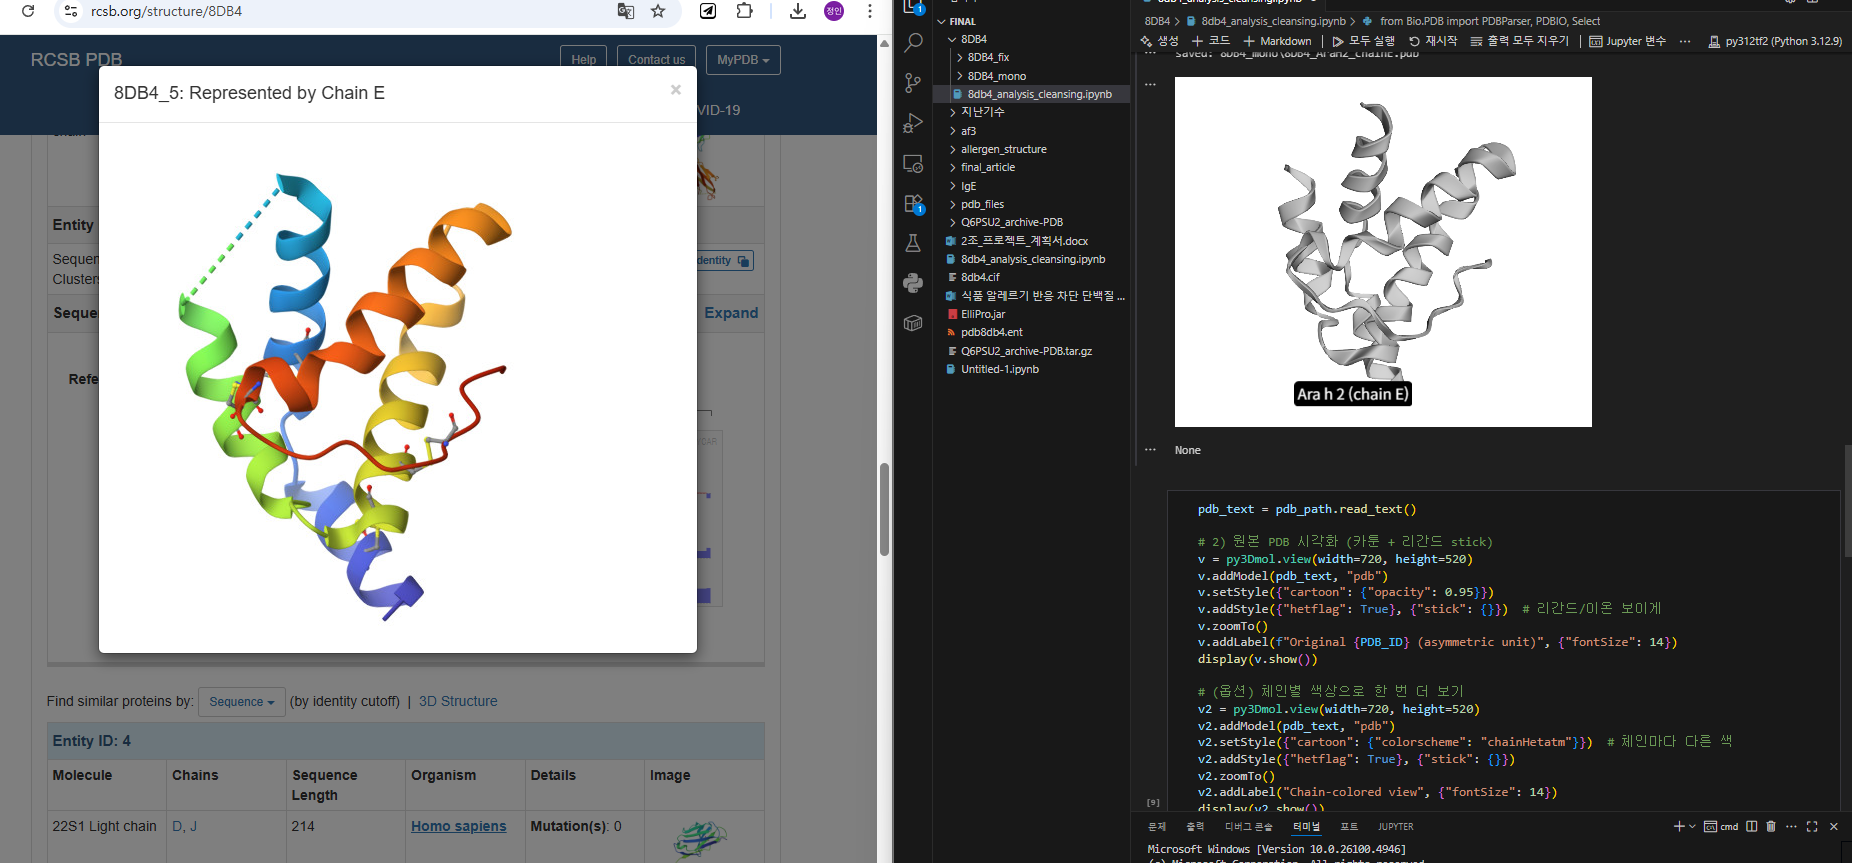

# + 8DB4 원본 PDB 파일 시각화

In [9]:
pdb_text = pdb_path.read_text()

# 2) 원본 PDB 시각화 (카툰 + 리간드 stick)
v = py3Dmol.view(width=720, height=520)
v.addModel(pdb_text, "pdb")
v.setStyle({"cartoon": {"opacity": 0.95}})
v.addStyle({"hetflag": True}, {"stick": {}})  # 리간드/이온 보이게
v.zoomTo()
v.addLabel(f"Original {PDB_ID} (asymmetric unit)", {"fontSize": 14})
display(v.show())

# (옵션) 체인별 색상으로 한 번 더 보기
v2 = py3Dmol.view(width=720, height=520)
v2.addModel(pdb_text, "pdb")
v2.setStyle({"cartoon": {"colorscheme": "chainHetatm"}})  # 체인마다 다른 색
v2.addStyle({"hetflag": True}, {"stick": {}})
v2.zoomTo()
v2.addLabel("Chain-colored view", {"fontSize": 14})
display(v2.show())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None

# HET(단백질 외 이온, 리간드) 유무 확인

### HET: Nonstandard residues (as well as ligands, ions and water)

In [12]:
from Bio.PDB import PDBParser
from pathlib import Path

pdb_path = Path("8DB4_mono/8DB4_AraH2_chainE.pdb")  # 정제본 경로
s = PDBParser(QUIET=True).get_structure("s", str(pdb_path))
E = s[0]["E"]

het_list = []
for res in E:
    hetflag, resseq, icode = res.id
    if hetflag != " ":  # 공백이 아니면 HET(리간드/물/비표준 등)
        het_list.append((hetflag, res.get_resname(), resseq, icode))

print(f"HET residues in chain E: {len(het_list)}")

if het_list:
    # 중복 없이 어떤 종류의 het이 있는지 확인
    kinds = sorted({r[1] for r in het_list})
    print("Kinds:", kinds[:20], ("..." if len(kinds) > 20 else ""))


HET residues in chain E: 13
Kinds: ['HOH', 'ZN'] 


# HET 제거

### altloc = alternate location (대체 위치).
결정 구조에서 같은 원자/잔기가 두 개 이상 위치로 관측될 때(구조적 무질서, 여러 회전형 등) 모델러가 겹치는 좌표를 서로 다른 label로 동시에 기록하는 방식

시각화/분석 도구에서 보통 한 가지만 선택(관례적으로 ‘A’ 선택)

In [13]:
from Bio.PDB import PDBParser, PDBIO, Select
from pathlib import Path

src = Path("8DB4_mono/8DB4_AraH2_chainE.pdb")
dst = Path("8DB4_mono/8DB4_AraH2_chainE_proteinOnly.pdb")

class ProteinOnlySelect(Select):
    def __init__(self, keep):
        self.keep = set(keep)
        
    def accept_chain(self, chain):
        return 1 if chain.id in self.keep else 0
    
    # " "(공백) = 표준 폴리펩타이드 의미. 즉 HOH/금속/리간드/비표준 아미노산(MSE, SEP 등)은 제외.
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0
    
    # altloc(대체위치) 공백 또는 ‘A’만 유지
    def accept_atom(self, atom):
        if atom.get_altloc() not in (" ", "A"):
            return 0

# 체인 E의 표준 아미노산 원자만 포함된 PDB 파일 생성
s = PDBParser(QUIET=True).get_structure("s", str(src))
io = PDBIO(); io.set_structure(s)
io.save(str(dst), select=ProteinOnlySelect({"E"}))
print("Saved protein-only PDB:", dst.resolve())

Saved protein-only PDB: D:\final\8DB4\8DB4_mono\8DB4_AraH2_chainE_proteinOnly.pdb


# HET 제거 여부 확인

In [15]:
from Bio.PDB import PDBParser
from pathlib import Path
from collections import Counter

protein_only = Path("8DB4_mono/8DB4_AraH2_chainE_proteinOnly.pdb")  # 정제 후 파일
original     = Path("8DB4_mono/8DB4_AraH2_chainE.pdb")              # (참고) 정제 전 파일

# HETATM 레코드 수 카운트
def count_hetatm_records(pdb_path: Path) -> int:
    n = 0
    with pdb_path.open() as f:
        for line in f:
            if line.startswith("HETATM"):
                n += 1
    return n

print("HETATM lines")
for p in [original, protein_only]:
    if p.exists():
        print(f"  {p.name}: {count_hetatm_records(p)}")

HETATM lines
  8DB4_AraH2_chainE.pdb: 13
  8DB4_AraH2_chainE_proteinOnly.pdb: 0


In [17]:
from pathlib import Path
import py3Dmol
from IPython.display import display

protein_only = Path("8DB4_mono/8DB4_AraH2_chainE_proteinOnly.pdb")
pdb_text = protein_only.read_text()

v = py3Dmol.view(width=700, height=520)
v.addModel(pdb_text, "pdb")
v.setStyle({"cartoon": {"opacity": 0.95}})

# 남아있는 HET이 있으면 스틱으로 보이게 (단백질만 존재하면 안 보임)
v.addStyle({"hetflag": True}, {"stick": {}})
v.zoomTo()
v.addLabel("Ara h 2 chain E (protein-only)", {"fontSize": 14})
display(v.show())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

None